In [2]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn requests flask

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import requests
import os
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [4]:
# Téléversement du fichier Excel
uploaded = files.upload()

# Charger le fichier téléversé (par exemple, "ur3_cobotops.xlsx")
filename = list(uploaded.keys())[0]  # Récupère le nom du fichier téléversé
df = pd.read_excel(filename)  # Utilisation de pandas pour lire le fichier Excel

# Affichage des premières lignes pour vérification
df.head()

Saving dataset_02052023.xlsx to dataset_02052023.xlsx


,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost
0,1,2022-10-26T08:17:21.847Z,0.109628,27.875,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,...,2.955651e-01,-0.000490,0.001310,-0.132836,-0.007479,-0.152962,0.082732,1,0.0,False
1,2,2022-10-26T08:17:22.852Z,0.595605,27.875,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,...,-7.391485e-30,-0.000304,0.002185,0.001668,-0.000767,0.000417,0.505895,1,0.0,False
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.875,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,...,1.369386e-01,0.007795,-2.535874,0.379867,0.000455,-0.496856,0.079420,1,0.0,False
3,4,2022-10-26T08:17:24.863Z,0.065053,27.875,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,...,-9.030032e-02,-0.004911,-0.009096,-0.384196,0.018411,0.425559,0.083325,1,0.0,False
4,5,2022-10-26T08:17:25.877Z,0.884140,27.875,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,...,1.268088e-01,0.005567,0.001138,-0.353284,0.014994,0.180989,0.086379,1,0.0,False


In [5]:
print("Dimensions du dataset :", df.shape)
print("\nColonnes disponibles :", df.columns.tolist())

Dimensions du dataset : (7409, 24)

Colonnes disponibles : ['Num', 'Timestamp', 'Current_J0', 'Temperature_T0', 'Current_J1', 'Temperature_J1', 'Current_J2', 'Temperature_J2', 'Current_J3', 'Temperature_J3', 'Current_J4', 'Temperature_J4', 'Current_J5', 'Temperature_J5', 'Speed_J0', 'Speed_J1', 'Speed_J2', 'Speed_J3', 'Speed_J4', 'Speed_J5', 'Tool_current', 'cycle ', 'Robot_ProtectiveStop', 'grip_lost']


In [6]:
print("\nRésumé statistique :\n", df.describe())


Résumé statistique :
                Num   Current_J0  Temperature_T0   Current_J1  Temperature_J1  \
count  7409.000000  7363.000000     7355.000000  7355.000000     7355.000000   
mean   3705.000000    -0.048934       34.906781    -2.297936       37.659636   
std    2138.938405     0.829395        2.762057     0.800450        3.247315   
min       1.000000    -6.247756       27.812500    -5.808734       29.312500   
25%    1853.000000    -0.195026       33.000000    -2.664919       35.375000   
50%    3705.000000    -0.080830       36.500000    -2.236342       39.687500   
75%    5557.000000     0.095959       37.062500    -1.778334       40.125000   
max    7409.000000     6.806938       37.250000     1.083596       40.500000   

        Current_J2  Temperature_J2   Current_J3  Temperature_J3   Current_J4  \
count  7355.000000     7355.000000  7355.000000     7355.000000  7355.000000   
mean     -1.199381       38.064064    -0.605312       40.936999    -0.022968   
std       0.6099

In [7]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes :\n", df.isnull().sum())


Valeurs manquantes :
 Num                      0
Timestamp                0
Current_J0              46
Temperature_T0          54
Current_J1              54
Temperature_J1          54
Current_J2              54
Temperature_J2          54
Current_J3              54
Temperature_J3          54
Current_J4              54
Temperature_J4          54
Current_J5              54
Temperature_J5          54
Speed_J0                54
Speed_J1                54
Speed_J2                54
Speed_J3                54
Speed_J4                54
Speed_J5                54
Tool_current            54
cycle                    0
Robot_ProtectiveStop    54
grip_lost                0
dtype: int64


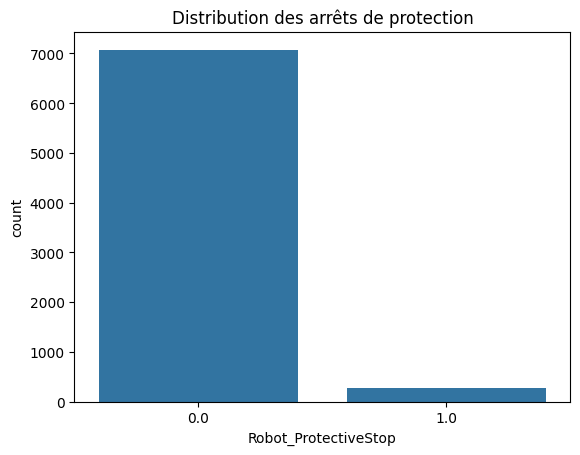

In [8]:
sns.countplot(x="Robot_ProtectiveStop", data=df)
plt.title("Distribution des arrêts de protection")
plt.show()

In [9]:
class_distribution = df["Robot_ProtectiveStop"].value_counts(normalize=True)
print("\nProportion des classes :\n", class_distribution)


Proportion des classes :
 Robot_ProtectiveStop
0.0    0.962203
1.0    0.037797
Name: proportion, dtype: float64


In [10]:
# Colonnes à supprimer
columns_to_drop = ['Num', 'Timestamp']

# Vérification que ces colonnes existent avant de les supprimer
for col in columns_to_drop:
    if col not in df.columns:
        print(f"Attention : {col} n'est pas dans le dataset.")
    else:
        print(f"{col} sera supprimé.")

# Suppression des colonnes non désirées
df_processed = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Sélection des features (toutes sauf la cible)
target = 'Robot_ProtectiveStop'
features = [col for col in df_processed.columns if col != target]

print("\nFeatures sélectionnées :", features)


Num sera supprimé.
Timestamp sera supprimé.

Features sélectionnées : ['Current_J0', 'Temperature_T0', 'Current_J1', 'Temperature_J1', 'Current_J2', 'Temperature_J2', 'Current_J3', 'Temperature_J3', 'Current_J4', 'Temperature_J4', 'Current_J5', 'Temperature_J5', 'Speed_J0', 'Speed_J1', 'Speed_J2', 'Speed_J3', 'Speed_J4', 'Speed_J5', 'Tool_current', 'cycle ', 'grip_lost']


In [11]:
# Supprimer la colonne Timestamp s’il le faut
df.drop(columns=['Timestamp'], inplace=True, errors='ignore')
# Encodage des colonnes catégorielles (si besoin)
df = pd.get_dummies(df, drop_first=True)


# Refaire imputation
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [35]:
# Normalisation (standardisation Z-score)
scaler = StandardScaler()

df_imputed.drop(columns=['Robot_ProtectiveStop'])
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)

In [36]:
import joblib

# Sauvegarde du scaler
joblib.dump(scaler, 'scaler.joblib')

# Sauvegarde de l’imputer (optionnel mais recommandé)
joblib.dump(imputer, 'imputer.joblib')

['imputer.joblib']

In [37]:
# Télécharger les fichiers sauvegardés
files.download('scaler.joblib')
files.download('imputer.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# Vérification rapide
df_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
Num,7409.0,6.137770e-17,1.000067,-1.731817,-0.865909,0.000000,0.865909,1.731817
Current_J0,7409.0,3.836106e-18,1.000067,-7.497731,-0.175412,-0.037039,0.173174,8.292460
Temperature_T0,7409.0,-1.288932e-15,1.000067,-2.578064,-0.692925,0.578976,0.783389,0.851527
Current_J1,7409.0,-1.419359e-16,1.000067,-4.402403,-0.456380,0.070707,0.647698,4.240308
Temperature_J1,7409.0,7.979101e-16,1.000067,-2.580067,-0.706172,0.626805,0.762034,0.877945
Current_J2,7409.0,-3.030524e-16,1.000067,-4.891403,-0.576381,0.195962,0.591545,6.029660
Temperature_J2,7409.0,1.902709e-15,1.000067,-2.633343,-0.682368,0.643537,0.719303,0.870835
Current_J3,7409.0,4.938986e-17,1.000067,-5.317099,-0.432513,0.062515,0.418963,5.605178
Temperature_J3,7409.0,0.000000e+00,1.000067,-2.779315,-0.630644,0.670386,0.690098,0.788661
Current_J4,7409.0,0.000000e+00,1.000067,-7.503360,-0.162318,0.014868,0.171786,6.543717


In [39]:
# Séparation des features et du label
X = df_scaled.drop(columns=['Robot_ProtectiveStop'])
# Convertir en entiers si ce sont bien des classes

# Redéfinir y directement ici
y = df_scaled['Robot_ProtectiveStop'].astype(int)

y = y.astype(int)
# Remplacer les 5 par 1
y = y.replace(5, 1)



# Appliquer SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Vérif équilibre
print(y_resampled.value_counts())


Robot_ProtectiveStop
0    7131
1    7131
Name: count, dtype: int64


In [40]:
import numpy as np

# Paramètres
sequence_length = 10  # nombre de pas de temps
X = X_resampled.values
y = y_resampled.values

# Création des séquences
X_sequences = []
y_sequences = []

for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print("Shape X:", X_sequences.shape)
print("Shape y:", y_sequences.shape)


Shape X: (14252, 10, 22)
Shape y: (14252,)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)




Train: (11401, 10, 22) (11401,)
Test: (2851, 10, 22) (2851,)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Modèle
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # pour classification binaire

# Compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Résumé
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,385 (95.25 KB)

 Trainable params: 24,385 (95.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8936 - loss: 0.3030 - val_accuracy: 0.9763 - val_loss: 0.0888
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9737 - loss: 0.0953 - val_accuracy: 0.9790 - val_loss: 0.0723
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9772 - loss: 0.0766 - val_accuracy: 0.9785 - val_loss: 0.0671
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9788 - loss: 0.0649 - val_accuracy: 0.9798 - val_loss: 0.0645
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9786 - loss: 0.0592 - val_accuracy: 0.9816 - val_loss: 0.0604
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9811 - loss: 0.0553 - val_accuracy: 0.9811 - val_loss: 0.0593
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9804 - loss: 0.0528 - val_accuracy: 0.9811 - val_loss: 0.0586
Epoch 8/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9811 - loss: 0.0502 - val_accuracy: 0.

In [44]:
# Évaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9811 - loss: 0.0447
Test Loss: 0.0454
Test Accuracy: 0.9811


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prédictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Rapport
print("Classification Report :\n")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("Matrice de confusion :\n")
print(confusion_matrix(y_test, y_pred))


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report :

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1424
           1       0.99      0.97      0.98      1427

    accuracy                           0.98      2851
   macro avg       0.98      0.98      0.98      2851
weighted avg       0.98      0.98      0.98      2851

Matrice de confusion :

[[1414   10]
 [  44 1383]]


In [72]:
# 1. Sélectionner un échantillon
# Sélectionner la ligne à l'index 3 (qui est la 4ème ligne en indexation de type 0)
sample = df.iloc[19:20]


# 2. Identifier automatiquement les colonnes catégorielles et numériques
cat_cols = sample.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = sample.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Encodage One-Hot
sample_encoded = pd.get_dummies(sample, columns=cat_cols)

# 4. IMPORTANT: Supprimer la colonne cible avant le scaling
#if 'Robot_ProtectiveStop' in sample_encoded.columns:
   # sample_encoded = sample_encoded.drop(columns=['Robot_ProtectiveStop'])

# 5. Scaling
sample_scaled = scaler.transform(sample_encoded)

# Si sample_scaled est un ndarray, il faut ré-aligner avec les colonnes d'origine
if isinstance(sample_scaled, np.ndarray):
    # Convertir sample_scaled en DataFrame pour ajouter des colonnes
    sample_scaled = pd.DataFrame(sample_scaled, columns=sample_encoded.columns)

# 6. Réaligner les colonnes avec celles utilisées pour l'entraînement
if hasattr(X, 'columns'):
    feature_columns = [col for col in X.columns if col != 'Robot_ProtectiveStop']
else:
    feature_columns = [col for col in df_scaled.columns if col != 'Robot_ProtectiveStop']

sample_scaled = sample_scaled.reindex(columns=feature_columns, fill_value=0)

# 7. Créer une séquence pour le LSTM
sequence = np.zeros((1, sequence_length, sample_scaled.shape[1]))
for i in range(sequence_length):
    sequence[0, i, :] = sample_scaled

# 8. Faire la prédiction
prediction = model.predict(sequence)

# 9. Afficher les résultats
result_text = "Arret de protection" if prediction[0][0] > 0.5 else "Pas d'arret"
print(f"Prédiction : {result_text}")
print(f"Probabilité : {prediction[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prédiction : Pas d'arret
Probabilité : 0.3333


In [73]:
joblib.dump(imputer, 'model.joblib')
files.download('model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>